In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import xgboost as xgb 
import warnings
import pickle
import requests
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')


def save_csv(df, name):
    df.to_csv("../Data/" + name)

              
def read_csv(name):
    return pd.read_csv("../Data/" + name)


def change_time(d):
    for i in range(len(d)):
        a, b = d[i].split(":")
        b, c = b.split(".")
        d[i] = int(a) * 60 + int(b) + int(c) * 0.1
    return d


def topn(d, n):
    d2 = list()
    for i in range(len(d)):
        if int(d[i]) <= n:
            d2.append(1)
        else:
            d2.append(0)
    return d2

def change_w(d):
    d2 = list()
    d3 = list()
    for i in range(len(d)):
        if not str(d[i]).isdigit():
            a, b = d[i].split("(")
            b, c = b.split(")")
        else:
            a = d[i]
            b = 0
        d2.append(int(a))
        d3.append(int(b))
    return d2, d3

def df_half(df, n, s):
    d = df.copy()
    for i in range(len(df)):
        if d.loc[i, s] != 1 and n > 0:
            d = d.drop(i)
            n -= 1
    return d

def point(df, df2):
    d = np.sqrt(1/df2.着順 ** 2 * 100)
    d[df2["着順"] <= 8] += 1.0/df2.着順*10
    return d
#     return np.sqrt(np.sqrt(df.単勝)/df2.着順 ** 2 * 100)[df2["着順"] <= 3]
#     return [int(3.0/i*10) if i < 6 else 0 for i in df["着順"]]

def favorite(df):
    d = np.sqrt(df.単勝 / df.人気 ** 5 * 100)
    return np.round(d, 5)

def seirei(df):
    d2 = list()
    d3 = list()
    for i in range(len(df)):
        a, b = df.性齢[i][0], df.性齢[i][1]
        d2.append(str(a))
        d3.append(int(b))
    return d2, d3

F:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = read_csv("results_2021")
def cre_df(df, f=False, le_sei=None, le_we=None, le_ra=None, le_ra2=None, le_gr=None, le_rp=None, le_tyo=None):
    df = df.rename(columns={'Unnamed: 0': 'id'})
    df = df.reindex(columns=['id', '枠番', '馬番', '馬名', '性齢', '斤量', '騎手',
           '単勝', '人気', '馬体重', '調教師', 'race_place', 'course_len', 
           'weather', 'race_type', 'race_type2', 'ground_state', 'date', 
             'horse_id', 'jockey_id', '着順', 'タイム', '着差'])
    df['着順'] = pd.to_numeric(df['着順'], errors="coerce")
    df = df.dropna(subset=['着順']).reset_index(drop=True)
    df = df.sort_values(["id", "枠番"], ascending=[True, True]).reset_index(drop=True)
    df['top3'] = topn(df['着順'], 3)
    df['top5'] = topn(df['着順'], 5)
    df2 = df[['id', '着順', 'タイム']]
    df = df.drop(['馬名', '騎手'], axis=1)
    df = df.drop(['着差', '馬番', '着順', 'タイム', 'top3', 'top5'], axis=1)
    df['性'], df['齢']  = seirei(df)
    if f:
        le_sei = LabelEncoder()
        le_we = LabelEncoder()
        le_ra = LabelEncoder()
        le_ra2 = LabelEncoder()
        le_gr = LabelEncoder()
        le_rp = LabelEncoder()
        le_tyo = LabelEncoder()
        df['性'] = le_sei.fit_transform(df['性'].values)
        df['weather'] = le_we.fit_transform(df['weather'].values)
        df['race_type'] = le_ra.fit_transform(df['race_type'].values)
        df['race_type2'] = le_ra2.fit_transform(df['race_type2'].values)
        df['ground_state'] = le_gr.fit_transform(df['ground_state'].values)
        df['race_place'] = le_rp.fit_transform(df['race_place'].values)
#         df['調教師'] = le_tyo.fit_transform(df['調教師'].values)
    else:
        df['性'] = le_sei.transform(df['性'].values)
        df['weather'] = le_we.transform(df['weather'].values)
        df['race_type'] = le_ra.transform(df['race_type'].values)
        df['race_type2'] = le_ra2.transform(df['race_type2'].values)
        df['ground_state'] = le_gr.transform(df['ground_state'].values)
        df['race_place'] = le_rp.transform(df['race_place'].values)
#         df['調教師'] = le_tyo.transform(df['調教師'].values)
    # le_ho = LabelEncoder()
    # df['horse_id'] = le_ho.fit_transform(df['horse_id'].values)
    # le_jo = LabelEncoder()
    # df['jockey_id'] = le_jo.fit_transform(df['jockey_id'].values)
#     le_co = LabelEncoder()
#     df['course_len'] = le_co.fit_transform(df['course_len'].values)
    df['horse_id'] = df['horse_id'].astype("int64")
    df['jockey_id'] = df['jockey_id'].astype("int64")
    df['course_len'] = df['course_len'].astype("int64")
#     df['馬体重'], df['馬体重差'] = change_w(df['馬体重'])
#     df['全体重'] = df.馬体重 + df.斤量
    df = df.drop(['馬体重'], axis=1)
    # df['馬体重差'] = preprocessing.minmax_scale(df['馬体重差'])
    df['人気'] = df['人気'].astype("int64")
    df['枠番'] = df['枠番'].astype("int64")
    df['単勝'] = df['単勝'].astype("float64")
    df2['着順'] = df2['着順'].astype("int64")
    df2['タイム'] = np.round(change_time(df2['タイム']).astype("float64"), 1)
    df['fav'] = favorite(df)
    df["date"] = pd.to_datetime(df['date'], format='%Y年%m月%d日')
#     df = df.reindex(columns=['id', "date", '枠番', '性', '齢', '斤量', '馬体重', '馬体重差', '全体重',
#     '単勝', '人気', 'fav','調教師', 'horse_id',
#     'jockey_id', 'race_place', 'course_len',
#     'weather', 'race_type', 'race_type2', 'ground_state'])
    df = df.reindex(columns=['horse_id', 'jockey_id', 'id', "date", '枠番', '性', '齢', '斤量',
    '単勝', '人気', 'fav','調教師','race_place', 'course_len',
    'weather', 'race_type', 'race_type2', 'ground_state'])
    df = df.drop(['調教師', 'jockey_id'], axis=1)
    if not f:
        return df, df2
    else:
        return df, df2, le_sei, le_we, le_ra, le_ra2, le_gr, le_rp, le_tyo
    
df, df2, le_sei, le_we, le_ra, le_ra2, le_gr, le_rp, le_tyo = cre_df(df, True)
que = list(df.groupby("id").size())
df = df.drop(['id'], axis=1)
# df = read_csv("df_2021").rename(columns={'Unnamed: 0': 'id'}).drop('id', axis=1)
df

,horse_id,date,枠番,性,齢,斤量,単勝,人気,fav,race_place,course_len,weather,race_type,race_type2,ground_state
0,2018100570,2021-06-12,1,1,3,54.0,3.7,1,19.23538,5,1200,0,1,0,2
1,2018104780,2021-06-12,1,2,3,56.0,10.4,6,0.36571,5,1200,0,1,0,2
2,2018101518,2021-06-12,2,1,3,52.0,275.3,16,0.16203,5,1200,0,1,0,2
3,2018101447,2021-06-12,2,2,3,56.0,57.7,11,0.18928,5,1200,0,1,0,2
4,2018105258,2021-06-12,3,2,3,56.0,3.9,2,3.49106,5,1200,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47471,2015110065,2021-09-05,6,0,6,57.0,82.5,11,0.22633,3,2600,2,1,0,2
47472,2017100368,2021-09-05,7,2,4,57.0,43.7,8,0.36519,3,2600,2,1,0,2
47473,2018104097,2021-09-05,7,2,3,53.0,46.5,9,0.28062,3,2600,2,1,0,2
47474,2017102850,2021-09-05,8,2,4,57.0,3.6,2,3.35410,3,2600,2,1,0,2


In [3]:
hor = read_csv("horse_2021")
hor = hor.rename(columns={'Unnamed: 0': 'id'})
hor = hor.sort_values(["id", "日付"], ascending=[True, True]).reset_index(drop=True)
hor = hor.drop(['映像', 'ﾀｲﾑ指数', '厩舎ｺﾒﾝﾄ', '備考', "R", "通過", "ペース",
              "勝ち馬(2着馬)", "馬場指数", "レース名", "馬番", "賞金"], axis=1)
hor = hor.dropna(subset=['天気', "枠番", "オッズ", "人気", "タイム", "上り", "着差"]).reset_index(drop=True)
hor["日付"] = pd.to_datetime(hor['日付'], format='%Y/%m/%d')
hor
l1, l2, l3, l4, l5 = [], [], [], [], []
for i in range(len(df)):
    l = hor.loc[hor[(df.loc[i, "date"] == hor["日付"]) & 
              (df.loc[i, "horse_id"] == hor["id"])].index[0] - 1, ["オッズ", "人気", "着順", "タイム", "距離"]]
    l1.append(l[0])
    l2.append(l[1])
    l3.append(l[2])
#     l4.append(l[3])
#     l5.append(l[4][1:])

df["前オッズ"] = l1
df["前人気"] = l2
df["前着順"] = l3
# df["前距離"] = l5
# df["前タイム"] = change_time(l4)
# df["前距離"] = df["前距離"].astype("int64")
# df["前スピード"] = df["前距離"] / df["前タイム"]
# df1 = df.copy()
df

,horse_id,date,枠番,性,齢,斤量,単勝,人気,fav,race_place,course_len,weather,race_type,race_type2,ground_state,前オッズ,前人気,前着順
0,2018100570,2021-06-12,1,1,3,54.0,3.7,1,19.23538,5,1200,0,1,0,2,2.7,1.0,11
1,2018104780,2021-06-12,1,2,3,56.0,10.4,6,0.36571,5,1200,0,1,0,2,5.6,3.0,2
2,2018101518,2021-06-12,2,1,3,52.0,275.3,16,0.16203,5,1200,0,1,0,2,372.5,15.0,16
3,2018101447,2021-06-12,2,2,3,56.0,57.7,11,0.18928,5,1200,0,1,0,2,42.2,12.0,13
4,2018105258,2021-06-12,3,2,3,56.0,3.9,2,3.49106,5,1200,0,1,0,2,3.8,2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47471,2015110065,2021-09-05,6,0,6,57.0,82.5,11,0.22633,3,2600,2,1,0,2,27.5,6.0,7
47472,2017100368,2021-09-05,7,2,4,57.0,43.7,8,0.36519,3,2600,2,1,0,2,13.1,5.0,6
47473,2018104097,2021-09-05,7,2,3,53.0,46.5,9,0.28062,3,2600,2,1,0,2,47.7,9.0,9
47474,2017102850,2021-09-05,8,2,4,57.0,3.6,2,3.35410,3,2600,2,1,0,2,5.1,3.0,4


In [4]:
df2['t'] = point(df, df2).astype("int64")
df2['スピード'] = df.course_len / df2.タイム
# df2 = read_csv("df2_2021").rename(columns={'Unnamed: 0': 'id2'}).drop('id2', axis=1)
df2

,id,着順,タイム,t,スピード
0,202101010101,6,69.0,3,17.391304
1,202101010101,15,70.2,0,17.094017
2,202101010101,10,69.6,1,17.241379
3,202101010101,12,69.9,0,17.167382
4,202101010101,2,68.8,10,17.441860
...,...,...,...,...,...
47471,202110040812,11,162.6,0,15.990160
47472,202110040812,8,162.2,2,16.029593
47473,202110040812,9,162.2,1,16.029593
47474,202110040812,1,161.0,20,16.149068


In [5]:
# save_csv(df, "df_2021")
# save_csv(df2, "df2_2021")

In [6]:
x = df.drop(["date"], axis=1).astype("float32")
y = df2['スピード']
x_train = x.iloc[:sum(que[:int(len(que) * 0.6)])]
x_valid = x.iloc[sum(que[:int(len(que) * 0.6)]):sum(que[:int(len(que) * 0.7)])]
x_test = x.iloc[sum(que[:int(len(que) * 0.7)]):]
y_train = y.iloc[:sum(que[:int(len(que) * 0.6)])]
y_valid = y.iloc[sum(que[:int(len(que) * 0.6)]):sum(que[:int(len(que) * 0.7)])]
y_test = y.iloc[sum(que[:int(len(que) * 0.7)]):]
train_query = que[:int(len(que) * 0.6)]
val_query = que[int(len(que) * 0.6):int(len(que) * 0.7)]
test_query = que[int(len(que) * 0.7):]
lgb_train = lgb.Dataset(x_train, y_train)
lgb_valid = lgb.Dataset(x_valid, y_valid, reference=lgb_train)
params = {
        'task': 'train',            
        'boosting_type': 'gbdt',   
        'objective': 'regression',  
        'metric': 'rmse',      
        'learning_rate': 0.001,
        'random_state': 0,
          }
model_s = lgb.train(params, lgb_train, num_boost_round=10000, valid_sets=lgb_valid, 
                  valid_names=['train','valid'], early_stopping_rounds=100, verbose_eval=-1)
importance = pd.DataFrame(model_s.feature_importance(), index=df.drop(["date"], axis=1).columns, columns=['importance'])
display(importance)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1152
[LightGBM] [Info] Number of data points in the train set: 29155, number of used features: 17
[LightGBM] [Info] Start training from score 16.245835
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2846]	train's rmse: 0.274039


,importance
horse_id,13835
枠番,1
性,449
齢,1945
斤量,236
単勝,9840
人気,1
fav,389
race_place,7563
course_len,19858


In [7]:
# model_s = pickle.load(open('../Data/model/lightgbm/model_s.pkl', 'rb'))

In [8]:
df["pred_s"] = model_s.predict(x, num_iteration=model_s.best_iteration)
df

,horse_id,date,枠番,性,齢,斤量,単勝,人気,fav,race_place,course_len,weather,race_type,race_type2,ground_state,前オッズ,前人気,前着順,pred_s
0,2018100570,2021-06-12,1,1,3,54.0,3.7,1,19.23538,5,1200,0,1,0,2,2.7,1.0,11,17.153452
1,2018104780,2021-06-12,1,2,3,56.0,10.4,6,0.36571,5,1200,0,1,0,2,5.6,3.0,2,17.148154
2,2018101518,2021-06-12,2,1,3,52.0,275.3,16,0.16203,5,1200,0,1,0,2,372.5,15.0,16,16.896135
3,2018101447,2021-06-12,2,2,3,56.0,57.7,11,0.18928,5,1200,0,1,0,2,42.2,12.0,13,17.027790
4,2018105258,2021-06-12,3,2,3,56.0,3.9,2,3.49106,5,1200,0,1,0,2,3.8,2.0,2,17.154444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47471,2015110065,2021-09-05,6,0,6,57.0,82.5,11,0.22633,3,2600,2,1,0,2,27.5,6.0,7,16.016377
47472,2017100368,2021-09-05,7,2,4,57.0,43.7,8,0.36519,3,2600,2,1,0,2,13.1,5.0,6,16.022843
47473,2018104097,2021-09-05,7,2,3,53.0,46.5,9,0.28062,3,2600,2,1,0,2,47.7,9.0,9,15.955428
47474,2017102850,2021-09-05,8,2,4,57.0,3.6,2,3.35410,3,2600,2,1,0,2,5.1,3.0,4,16.022019


In [9]:
x = df.drop(["date"], axis=1).astype("float32")
y = df2['タイム']
x_train = x.iloc[:sum(que[:int(len(que) * 0.6)])]
x_valid = x.iloc[sum(que[:int(len(que) * 0.6)]):sum(que[:int(len(que) * 0.7)])]
x_test = x.iloc[sum(que[:int(len(que) * 0.7)]):]
y_train = y.iloc[:sum(que[:int(len(que) * 0.6)])]
y_valid = y.iloc[sum(que[:int(len(que) * 0.6)]):sum(que[:int(len(que) * 0.7)])]
y_test = y.iloc[sum(que[:int(len(que) * 0.7)]):]
train_query = que[:int(len(que) * 0.6)]
val_query = que[int(len(que) * 0.6):int(len(que) * 0.7)]
test_query = que[int(len(que) * 0.7):]
lgb_train = lgb.Dataset(x_train, y_train)
lgb_valid = lgb.Dataset(x_valid, y_valid, reference=lgb_train)
# lgb_test = lgb.Dataset(x_test, y_test, reference=lgb_train)
params = {
        'task': 'train',            
        'boosting_type': 'gbdt',   
        'objective': 'regression',  
        'metric': 'rmse',      
        'learning_rate': 0.001,
        'random_state': 0,
#         'device':'gpu',
#         '-DUSE_GPU' : 1,
    
          }
model_t = lgb.train(params, lgb_train, num_boost_round=10000, valid_sets=lgb_valid, 
                  valid_names=['train','valid'], early_stopping_rounds=100, verbose_eval=-1)
importance = pd.DataFrame(model_t.feature_importance(), index=df.drop(["date"], axis=1).columns, columns=['importance'])
display(importance)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1407
[LightGBM] [Info] Number of data points in the train set: 29155, number of used features: 18
[LightGBM] [Info] Start training from score 102.229892
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3838]	train's rmse: 2.02922


,importance
horse_id,1929
枠番,0
性,347
齢,0
斤量,1323
単勝,1048
人気,49
fav,534
race_place,2172
course_len,51996


In [10]:
# model_t = pickle.load(open('../Data/model/lightgbm/model_t.pkl', 'rb'))

In [11]:
df["pred_t"] = model_t.predict(x, num_iteration=model_t.best_iteration)
# df["pred_s"] = df["course_len"] / df["pred_t"]
df

,horse_id,date,枠番,性,齢,斤量,単勝,人気,fav,race_place,course_len,weather,race_type,race_type2,ground_state,前オッズ,前人気,前着順,pred_s,pred_t
0,2018100570,2021-06-12,1,1,3,54.0,3.7,1,19.23538,5,1200,0,1,0,2,2.7,1.0,11,17.153452,70.271268
1,2018104780,2021-06-12,1,2,3,56.0,10.4,6,0.36571,5,1200,0,1,0,2,5.6,3.0,2,17.148154,70.315416
2,2018101518,2021-06-12,2,1,3,52.0,275.3,16,0.16203,5,1200,0,1,0,2,372.5,15.0,16,16.896135,71.428741
3,2018101447,2021-06-12,2,2,3,56.0,57.7,11,0.18928,5,1200,0,1,0,2,42.2,12.0,13,17.027790,70.854708
4,2018105258,2021-06-12,3,2,3,56.0,3.9,2,3.49106,5,1200,0,1,0,2,3.8,2.0,2,17.154444,70.271268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47471,2015110065,2021-09-05,6,0,6,57.0,82.5,11,0.22633,3,2600,2,1,0,2,27.5,6.0,7,16.016377,161.678886
47472,2017100368,2021-09-05,7,2,4,57.0,43.7,8,0.36519,3,2600,2,1,0,2,13.1,5.0,6,16.022843,161.678886
47473,2018104097,2021-09-05,7,2,3,53.0,46.5,9,0.28062,3,2600,2,1,0,2,47.7,9.0,9,15.955428,162.314611
47474,2017102850,2021-09-05,8,2,4,57.0,3.6,2,3.35410,3,2600,2,1,0,2,5.1,3.0,4,16.022019,161.678886


In [12]:
x = df.drop(["date"], axis=1).astype("float32")
y = pd.DataFrame(topn(df2['着順'], 5))
x_train = x.iloc[:sum(que[:int(len(que) * 0.8)])]
x_valid = x.iloc[sum(que[:int(len(que) * 0.8)]):sum(que[:int(len(que) * 0.9)])]
x_test = x.iloc[sum(que[:int(len(que) * 0.9)]):]
y_train = y.iloc[:sum(que[:int(len(que) * 0.8)])]
y_valid = y.iloc[sum(que[:int(len(que) * 0.8)]):sum(que[:int(len(que) * 0.9)])]
y_test = y.iloc[sum(que[:int(len(que) * 0.9)]):]
w = pd.DataFrame(index=x_train.index)
w = (y_train == 1)
w[0] = w[0] * 1 + 1
lgb_train = lgb.Dataset(x_train, y_train, weight=w[0])
lgb_valid = lgb.Dataset(x_valid, y_valid, reference=lgb_train)
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',#'auc'
    'learning_rate': 0.001,
    'random_state': 0,
}
model_5 = lgb.train(params, lgb_train, num_boost_round=10000, valid_sets=lgb_valid, 
                  valid_names=['train','valid'], early_stopping_rounds=100, verbose_eval=-1)
importance = pd.DataFrame(model_5.feature_importance(), index=df.drop(["date"], axis=1).columns, columns=['importance'])
display(importance)

[LightGBM] [Info] Number of positive: 13829, number of negative: 24489
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1674
[LightGBM] [Info] Number of data points in the train set: 38318, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.530385 -> initscore=0.121691
[LightGBM] [Info] Start training from score 0.121691
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3096]	train's binary_logloss: 0.562943


,importance
horse_id,9578
枠番,2057
性,924
齢,1500
斤量,1938
単勝,24462
人気,2893
fav,14097
race_place,1948
course_len,1093


In [13]:
# model_5 = pickle.load(open('../Data/model/lightgbm/model_5.pkl', 'rb'))

In [14]:
df["pred_5"] = pd.DataFrame(model_5.predict(x, num_iteration=
                     model_5.best_iteration))
# .applymap(lambda xx : 0 if xx<=0.5 else 1)
df

,horse_id,date,枠番,性,齢,斤量,単勝,人気,fav,race_place,course_len,weather,race_type,race_type2,ground_state,前オッズ,前人気,前着順,pred_s,pred_t,pred_5
0,2018100570,2021-06-12,1,1,3,54.0,3.7,1,19.23538,5,1200,0,1,0,2,2.7,1.0,11,17.153452,70.271268,0.815203
1,2018104780,2021-06-12,1,2,3,56.0,10.4,6,0.36571,5,1200,0,1,0,2,5.6,3.0,2,17.148154,70.315416,0.666544
2,2018101518,2021-06-12,2,1,3,52.0,275.3,16,0.16203,5,1200,0,1,0,2,372.5,15.0,16,16.896135,71.428741,0.083888
3,2018101447,2021-06-12,2,2,3,56.0,57.7,11,0.18928,5,1200,0,1,0,2,42.2,12.0,13,17.027790,70.854708,0.286990
4,2018105258,2021-06-12,3,2,3,56.0,3.9,2,3.49106,5,1200,0,1,0,2,3.8,2.0,2,17.154444,70.271268,0.800302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47471,2015110065,2021-09-05,6,0,6,57.0,82.5,11,0.22633,3,2600,2,1,0,2,27.5,6.0,7,16.016377,161.678886,0.277439
47472,2017100368,2021-09-05,7,2,4,57.0,43.7,8,0.36519,3,2600,2,1,0,2,13.1,5.0,6,16.022843,161.678886,0.502155
47473,2018104097,2021-09-05,7,2,3,53.0,46.5,9,0.28062,3,2600,2,1,0,2,47.7,9.0,9,15.955428,162.314611,0.404766
47474,2017102850,2021-09-05,8,2,4,57.0,3.6,2,3.35410,3,2600,2,1,0,2,5.1,3.0,4,16.022019,161.678886,0.860116


In [15]:
x = df.drop(["date"], axis=1).astype("float32")
y = pd.DataFrame(topn(df2['着順'], 3))
x_train = x.iloc[:sum(que[:int(len(que) * 0.8)])]
x_valid = x.iloc[sum(que[:int(len(que) * 0.8)]):sum(que[:int(len(que) * 0.9)])]
x_test = x.iloc[sum(que[:int(len(que) * 0.9)]):]
y_train = y.iloc[:sum(que[:int(len(que) * 0.8)])]
y_valid = y.iloc[sum(que[:int(len(que) * 0.8)]):sum(que[:int(len(que) * 0.9)])]
y_test = y.iloc[sum(que[:int(len(que) * 0.9)]):]
w = pd.DataFrame(index=x_train.index)
w = (y_train == 1)
w[0] = w[0] * 3 + 1
lgb_train = lgb.Dataset(x_train, y_train, weight=w[0])
lgb_valid = lgb.Dataset(x_valid, y_valid, reference=lgb_train)
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',#'auc'
    'learning_rate': 0.001,
    'random_state': 0,
}
model_3 = lgb.train(params, lgb_train, num_boost_round=10000, valid_sets=lgb_valid, 
                  valid_names=['train','valid'], early_stopping_rounds=100, verbose_eval=-1)
importance = pd.DataFrame(model_3.feature_importance(), index=df.drop(["date"], axis=1).columns, columns=['importance'])
display(importance)

[LightGBM] [Info] Number of positive: 8300, number of negative: 30018
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1929
[LightGBM] [Info] Number of data points in the train set: 38318, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.525167 -> initscore=0.100753
[LightGBM] [Info] Start training from score 0.100753
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3192]	train's binary_logloss: 0.560284


,importance
horse_id,5745
枠番,2201
性,994
齢,124
斤量,1631
単勝,15258
人気,4790
fav,9441
race_place,1800
course_len,595


In [16]:
# model_3 = pickle.load(open('../Data/model/lightgbm/model_3.pkl', 'rb'))

In [17]:
df["pred_3"] = pd.DataFrame(model_3.predict(x, num_iteration=
                     model_3.best_iteration))
df

,horse_id,date,枠番,性,齢,斤量,単勝,人気,fav,race_place,course_len,weather,race_type,race_type2,ground_state,前オッズ,前人気,前着順,pred_s,pred_t,pred_5,pred_3
0,2018100570,2021-06-12,1,1,3,54.0,3.7,1,19.23538,5,1200,0,1,0,2,2.7,1.0,11,17.153452,70.271268,0.815203,0.800463
1,2018104780,2021-06-12,1,2,3,56.0,10.4,6,0.36571,5,1200,0,1,0,2,5.6,3.0,2,17.148154,70.315416,0.666544,0.649706
2,2018101518,2021-06-12,2,1,3,52.0,275.3,16,0.16203,5,1200,0,1,0,2,372.5,15.0,16,16.896135,71.428741,0.083888,0.040074
3,2018101447,2021-06-12,2,2,3,56.0,57.7,11,0.18928,5,1200,0,1,0,2,42.2,12.0,13,17.027790,70.854708,0.286990,0.151254
4,2018105258,2021-06-12,3,2,3,56.0,3.9,2,3.49106,5,1200,0,1,0,2,3.8,2.0,2,17.154444,70.271268,0.800302,0.762711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47471,2015110065,2021-09-05,6,0,6,57.0,82.5,11,0.22633,3,2600,2,1,0,2,27.5,6.0,7,16.016377,161.678886,0.277439,0.176766
47472,2017100368,2021-09-05,7,2,4,57.0,43.7,8,0.36519,3,2600,2,1,0,2,13.1,5.0,6,16.022843,161.678886,0.502155,0.436141
47473,2018104097,2021-09-05,7,2,3,53.0,46.5,9,0.28062,3,2600,2,1,0,2,47.7,9.0,9,15.955428,162.314611,0.404766,0.392535
47474,2017102850,2021-09-05,8,2,4,57.0,3.6,2,3.35410,3,2600,2,1,0,2,5.1,3.0,4,16.022019,161.678886,0.860116,0.860528


In [18]:
x = df.drop(["date"], axis=1).astype("float32")
y = pd.DataFrame(topn(df2['着順'], 2))
x_train = x.iloc[:sum(que[:int(len(que) * 0.8)])]
x_valid = x.iloc[sum(que[:int(len(que) * 0.8)]):sum(que[:int(len(que) * 0.9)])]
x_test = x.iloc[sum(que[:int(len(que) * 0.9)]):]
y_train = y.iloc[:sum(que[:int(len(que) * 0.8)])]
y_valid = y.iloc[sum(que[:int(len(que) * 0.8)]):sum(que[:int(len(que) * 0.9)])]
y_test = y.iloc[sum(que[:int(len(que) * 0.9)]):]
w = pd.DataFrame(index=x_train.index)
w = (y_train == 1)
w[0] = w[0] * 5 + 1
lgb_train = lgb.Dataset(x_train, y_train, weight=w[0])
lgb_valid = lgb.Dataset(x_valid, y_valid, reference=lgb_train)
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',#'auc'
    'learning_rate': 0.001,
    'random_state': 0,
}
model_2 = lgb.train(params, lgb_train, num_boost_round=10000, valid_sets=lgb_valid, 
                  valid_names=['train','valid'], early_stopping_rounds=100, verbose_eval=-1)
importance = pd.DataFrame(model_2.feature_importance(), index=df.drop(["date"], axis=1).columns, columns=['importance'])
display(importance)

[LightGBM] [Info] Number of positive: 5532, number of negative: 32786
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2184
[LightGBM] [Info] Number of data points in the train set: 38318, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503077 -> initscore=0.012307
[LightGBM] [Info] Start training from score 0.012307
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2181]	train's binary_logloss: 0.542958


,importance
horse_id,3135
枠番,2317
性,136
齢,2
斤量,715
単勝,5156
人気,518
fav,3420
race_place,819
course_len,67


In [19]:
# model_2 = pickle.load(open('../Data/model/lightgbm/model_2.pkl', 'rb'))

In [20]:
df["pred_2"] = pd.DataFrame(model_2.predict(x, num_iteration=
                     model_2.best_iteration))
df

,horse_id,date,枠番,性,齢,斤量,単勝,人気,fav,race_place,course_len,weather,race_type,race_type2,ground_state,前オッズ,前人気,前着順,pred_s,pred_t,pred_5,pred_3,pred_2
0,2018100570,2021-06-12,1,1,3,54.0,3.7,1,19.23538,5,1200,0,1,0,2,2.7,1.0,11,17.153452,70.271268,0.815203,0.800463,0.734783
1,2018104780,2021-06-12,1,2,3,56.0,10.4,6,0.36571,5,1200,0,1,0,2,5.6,3.0,2,17.148154,70.315416,0.666544,0.649706,0.595389
2,2018101518,2021-06-12,2,1,3,52.0,275.3,16,0.16203,5,1200,0,1,0,2,372.5,15.0,16,16.896135,71.428741,0.083888,0.040074,0.061364
3,2018101447,2021-06-12,2,2,3,56.0,57.7,11,0.18928,5,1200,0,1,0,2,42.2,12.0,13,17.027790,70.854708,0.286990,0.151254,0.074106
4,2018105258,2021-06-12,3,2,3,56.0,3.9,2,3.49106,5,1200,0,1,0,2,3.8,2.0,2,17.154444,70.271268,0.800302,0.762711,0.715610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47471,2015110065,2021-09-05,6,0,6,57.0,82.5,11,0.22633,3,2600,2,1,0,2,27.5,6.0,7,16.016377,161.678886,0.277439,0.176766,0.083345
47472,2017100368,2021-09-05,7,2,4,57.0,43.7,8,0.36519,3,2600,2,1,0,2,13.1,5.0,6,16.022843,161.678886,0.502155,0.436141,0.419261
47473,2018104097,2021-09-05,7,2,3,53.0,46.5,9,0.28062,3,2600,2,1,0,2,47.7,9.0,9,15.955428,162.314611,0.404766,0.392535,0.391951
47474,2017102850,2021-09-05,8,2,4,57.0,3.6,2,3.35410,3,2600,2,1,0,2,5.1,3.0,4,16.022019,161.678886,0.860116,0.860528,0.817015


In [21]:
x = df.drop(["date"], axis=1).astype("float32")
y = pd.DataFrame(topn(df2['着順'], 1))
x_train = x.iloc[:sum(que[:int(len(que) * 0.8)])]
x_valid = x.iloc[sum(que[:int(len(que) * 0.8)]):sum(que[:int(len(que) * 0.9)])]
x_test = x.iloc[sum(que[:int(len(que) * 0.9)]):]
y_train = y.iloc[:sum(que[:int(len(que) * 0.8)])]
y_valid = y.iloc[sum(que[:int(len(que) * 0.8)]):sum(que[:int(len(que) * 0.9)])]
y_test = y.iloc[sum(que[:int(len(que) * 0.9)]):]
w = pd.DataFrame(index=x_train.index)
w = (y_train == 1)
w[0] = w[0] * 7 + 1
lgb_train = lgb.Dataset(x_train, y_train, weight=w[0])
lgb_valid = lgb.Dataset(x_valid, y_valid, reference=lgb_train)
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',#'auc'
    'learning_rate': 0.001,
    'random_state': 0,
}
model_1 = lgb.train(params, lgb_train, num_boost_round=10000, valid_sets=lgb_valid, 
                  valid_names=['train','valid'], early_stopping_rounds=100, verbose_eval=-1)
importance = pd.DataFrame(model_1.feature_importance(), index=df.drop(["date"], axis=1).columns, columns=['importance'])
display(importance)

[LightGBM] [Info] Number of positive: 2772, number of negative: 35546
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2438
[LightGBM] [Info] Number of data points in the train set: 38318, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384186 -> initscore=-0.471817
[LightGBM] [Info] Start training from score -0.471817
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3840]	train's binary_logloss: 0.399717


,importance
horse_id,7699
枠番,3147
性,801
齢,189
斤量,1904
単勝,10015
人気,1946
fav,6851
race_place,1889
course_len,819


In [22]:
# model_1 = pickle.load(open('../Data/model/lightgbm/model_1.pkl', 'rb'))

In [23]:
df["pred_1"] = pd.DataFrame(model_1.predict(x, num_iteration=
                     model_1.best_iteration))
df["pred_1235"] = df.pred_5 + df.pred_3 + df.pred_2 + df.pred_1
df["pred_123"] =  df.pred_3 + df.pred_2 + df.pred_1
df

,horse_id,date,枠番,性,齢,斤量,単勝,人気,fav,race_place,course_len,weather,race_type,race_type2,ground_state,前オッズ,前人気,前着順,pred_s,pred_t,pred_5,pred_3,pred_2,pred_1,pred_1235,pred_123
0,2018100570,2021-06-12,1,1,3,54.0,3.7,1,19.23538,5,1200,0,1,0,2,2.7,1.0,11,17.153452,70.271268,0.815203,0.800463,0.734783,0.693719,3.044167,2.228965
1,2018104780,2021-06-12,1,2,3,56.0,10.4,6,0.36571,5,1200,0,1,0,2,5.6,3.0,2,17.148154,70.315416,0.666544,0.649706,0.595389,0.469384,2.381023,1.714479
2,2018101518,2021-06-12,2,1,3,52.0,275.3,16,0.16203,5,1200,0,1,0,2,372.5,15.0,16,16.896135,71.428741,0.083888,0.040074,0.061364,0.011709,0.197036,0.113148
3,2018101447,2021-06-12,2,2,3,56.0,57.7,11,0.18928,5,1200,0,1,0,2,42.2,12.0,13,17.027790,70.854708,0.286990,0.151254,0.074106,0.012311,0.524661,0.237671
4,2018105258,2021-06-12,3,2,3,56.0,3.9,2,3.49106,5,1200,0,1,0,2,3.8,2.0,2,17.154444,70.271268,0.800302,0.762711,0.715610,0.609443,2.888066,2.087764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47471,2015110065,2021-09-05,6,0,6,57.0,82.5,11,0.22633,3,2600,2,1,0,2,27.5,6.0,7,16.016377,161.678886,0.277439,0.176766,0.083345,0.012813,0.550363,0.272924
47472,2017100368,2021-09-05,7,2,4,57.0,43.7,8,0.36519,3,2600,2,1,0,2,13.1,5.0,6,16.022843,161.678886,0.502155,0.436141,0.419261,0.281895,1.639451,1.137296
47473,2018104097,2021-09-05,7,2,3,53.0,46.5,9,0.28062,3,2600,2,1,0,2,47.7,9.0,9,15.955428,162.314611,0.404766,0.392535,0.391951,0.285211,1.474463,1.069697
47474,2017102850,2021-09-05,8,2,4,57.0,3.6,2,3.35410,3,2600,2,1,0,2,5.1,3.0,4,16.022019,161.678886,0.860116,0.860528,0.817015,0.717083,3.254742,2.394626


In [24]:
x = df.drop(["date"], axis=1).astype("float32")
y = df2['着順']
x_train = x.iloc[:sum(que[:int(len(que) * 0.8)])]
x_valid = x.iloc[sum(que[:int(len(que) * 0.8)]):sum(que[:int(len(que) * 0.9)])]
x_test = x.iloc[sum(que[:int(len(que) * 0.9)]):]
y_train = y.iloc[:sum(que[:int(len(que) * 0.8)])]
y_valid = y.iloc[sum(que[:int(len(que) * 0.8)]):sum(que[:int(len(que) * 0.9)])]
y_test = y.iloc[sum(que[:int(len(que) * 0.9)]):]
lgb_train = lgb.Dataset(x_train, y_train)
lgb_valid = lgb.Dataset(x_valid, y_valid, reference=lgb_train)
params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': y.max() + 1,
        'metric': 'multi_logloss',
        'learning_rate': 0.001,
        'random_state': 0,
          }
model_m = lgb.train(params, lgb_train, num_boost_round=10000, valid_sets=lgb_valid, 
                  valid_names=['train','valid'], early_stopping_rounds=100, verbose_eval=-1)
importance = pd.DataFrame(model_m.feature_importance(), index=df.drop(["date"], axis=1).columns, columns=['importance'])
display(importance)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3203
[LightGBM] [Info] Number of data points in the train set: 38318, number of used features: 25
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -2.626351
[LightGBM] [Info] Start training from score -2.630689
[LightGBM] [Info] Start training from score -2.627795
[LightGBM] [Info] Start training from score -2.628879
[LightGBM] [Info] Start training from score -2.629241
[LightGBM] [Info] Start training from score -2.631777
[LightGBM] [Info] Start training from score -2.632139
[LightGBM] [Info] Start training from score -2.644920
[LightGBM] [Info] Start training from score -2.681601
[LightGBM] [Info] Start training from score -2.726035
[LightGBM] [Info] Start training from score -2.79

,importance
horse_id,67690
枠番,28180
性,6561
齢,2030
斤量,18474
単勝,65591
人気,28574
fav,74960
race_place,17262
course_len,7792


In [25]:
# model_m = pickle.load(open('../Data/model/lightgbm/model_m.pkl', 'rb'))

In [26]:
df["pred_m"] = np.argmax(model_m.predict(x, 
            num_iteration=model_m.best_iteration), axis=1)
df

,horse_id,date,枠番,性,齢,斤量,単勝,人気,fav,race_place,course_len,weather,race_type,race_type2,ground_state,前オッズ,前人気,前着順,pred_s,pred_t,pred_5,pred_3,pred_2,pred_1,pred_1235,pred_123,pred_m
0,2018100570,2021-06-12,1,1,3,54.0,3.7,1,19.23538,5,1200,0,1,0,2,2.7,1.0,11,17.153452,70.271268,0.815203,0.800463,0.734783,0.693719,3.044167,2.228965,1
1,2018104780,2021-06-12,1,2,3,56.0,10.4,6,0.36571,5,1200,0,1,0,2,5.6,3.0,2,17.148154,70.315416,0.666544,0.649706,0.595389,0.469384,2.381023,1.714479,3
2,2018101518,2021-06-12,2,1,3,52.0,275.3,16,0.16203,5,1200,0,1,0,2,372.5,15.0,16,16.896135,71.428741,0.083888,0.040074,0.061364,0.011709,0.197036,0.113148,16
3,2018101447,2021-06-12,2,2,3,56.0,57.7,11,0.18928,5,1200,0,1,0,2,42.2,12.0,13,17.027790,70.854708,0.286990,0.151254,0.074106,0.012311,0.524661,0.237671,10
4,2018105258,2021-06-12,3,2,3,56.0,3.9,2,3.49106,5,1200,0,1,0,2,3.8,2.0,2,17.154444,70.271268,0.800302,0.762711,0.715610,0.609443,2.888066,2.087764,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47471,2015110065,2021-09-05,6,0,6,57.0,82.5,11,0.22633,3,2600,2,1,0,2,27.5,6.0,7,16.016377,161.678886,0.277439,0.176766,0.083345,0.012813,0.550363,0.272924,12
47472,2017100368,2021-09-05,7,2,4,57.0,43.7,8,0.36519,3,2600,2,1,0,2,13.1,5.0,6,16.022843,161.678886,0.502155,0.436141,0.419261,0.281895,1.639451,1.137296,5
47473,2018104097,2021-09-05,7,2,3,53.0,46.5,9,0.28062,3,2600,2,1,0,2,47.7,9.0,9,15.955428,162.314611,0.404766,0.392535,0.391951,0.285211,1.474463,1.069697,5
47474,2017102850,2021-09-05,8,2,4,57.0,3.6,2,3.35410,3,2600,2,1,0,2,5.1,3.0,4,16.022019,161.678886,0.860116,0.860528,0.817015,0.717083,3.254742,2.394626,1


In [27]:
x = df.drop(["date"], axis=1).astype("float32")
y = df2['t']
x_train = x.iloc[:sum(que[:int(len(que) * 0.8)])]
x_valid = x.iloc[sum(que[:int(len(que) * 0.8)]):sum(que[:int(len(que) * 0.9)])]
x_test = x.iloc[sum(que[:int(len(que) * 0.9)]):]
y_train = y.iloc[:sum(que[:int(len(que) * 0.8)])]
y_valid = y.iloc[sum(que[:int(len(que) * 0.8)]):sum(que[:int(len(que) * 0.9)])]
y_test = y.iloc[sum(que[:int(len(que) * 0.9)]):]
train_query = que[:int(len(que) * 0.8)]
val_query = que[int(len(que) * 0.8):int(len(que) * 0.9)]
test_query = que[int(len(que) * 0.9):]
lgb_train = lgb.Dataset(x_train, y_train, group=train_query)
lgb_valid = lgb.Dataset(x_valid, y_valid, reference=lgb_train, group=val_query)
# lgb_test = lgb.Dataset(x_test, y_test, reference=lgb_train)
y2 = df2['着順']
y2_test = y2.iloc[sum(que[:int(len(que) * 0.9)]):]
y3 = df2['id']
y3_test = y3.iloc[sum(que[:int(len(que) * 0.9)]):]
lgbm_params = {
    'objective': 'lambdarank',
   'metric': 'ndcg',
   'lambdarank_truncation_level': 30,
   'ndcg_eval_at': list(range(1, 6)),
   'learning_rate': 0.001,
   'boosting_type': 'gbdt',
   'random_state': 0,
    'label_gain': [i for i in range(int(max(y) + 1) + 1)],
    'force_row_wise': True,
}
model = lgb.train(lgbm_params, lgb_train, num_boost_round=1000, valid_sets=lgb_valid, 
                  valid_names=['train','valid'], verbose_eval=-1)
importance = pd.DataFrame(model.feature_importance(), index=df.drop(["date"], axis=1).columns, columns=['importance'])
display(importance)

[LightGBM] [Info] Total Bins 3222
[LightGBM] [Info] Number of data points in the train set: 38318, number of used features: 26


,importance
horse_id,2351
枠番,866
性,79
齢,7
斤量,207
単勝,1843
人気,113
fav,1179
race_place,334
course_len,69


In [28]:
# model = pickle.load(open('../Data/model/lightgbm/model.pkl', 'rb'))

In [29]:
pickle.dump(model_t, open('../Data/model/lightgbm/model_t.pkl', 'wb'))
pickle.dump(model_s, open('../Data/model/lightgbm/model_s.pkl', 'wb'))
pickle.dump(model_m, open('../Data/model/lightgbm/model_m.pkl', 'wb'))
pickle.dump(model_5, open('../Data/model/lightgbm/model_5.pklt', 'wb'))
pickle.dump(model_3, open('../Data/model/lightgbm/model_3.pkl', 'wb'))
pickle.dump(model_2, open('../Data/model/lightgbm/model_2.pkl', 'wb'))
pickle.dump(model_1, open('../Data/model/lightgbm/model_1.pkl', 'wb'))
pickle.dump(model, open('../Data/model/lightgbm/model.pkl', 'wb'))

In [30]:
# テストデータを予測する
pred = model.predict(x_test, num_iteration=model.best_iteration)
# pred = preprocessing.minmax_scale(pred)
pred

array([-1.11686741, -1.1885002 , -0.81784873, ..., -0.66914619,
        0.43771449, -0.70223981])

In [31]:
pre = []
for i in range(len(pred)):
    pre.append([y3_test.iloc[i], pred[i], y2_test.iloc[i]])
pre = pd.DataFrame(pre, columns=['id', 'pred', 'rank'])
pre = pre.sort_values(["id", "pred"], ascending=[True, False]).reset_index(drop=True)
pre["id"] = pre["id"].astype("int64")
pre["rank"] = pre["rank"].astype("int64")
pre

,id,pred,rank
0,202110010203,0.470462,4
1,202110010203,0.424857,5
2,202110010203,-0.047701,8
3,202110010203,-0.128613,13
4,202110010203,-0.168402,3
...,...,...,...
4698,202110040812,-0.662374,8
4699,202110040812,-0.669146,9
4700,202110040812,-0.702240,10
4701,202110040812,-1.076039,7


In [32]:
pre2 = []
nid = pre.loc[0, "id"]
dob_f, tri_f = True, True
a, b = 0, 0
c = [0, 0, 0]
for i in range(len(test_query)):
    for j in range(3):
        pre2.append(list(pre.loc[sum(test_query[:i]) + j]))
        a += 1
        if pre2[-1][2] <= 3:
            b += 1
        if pre2[-1][2] == 1:
            if j == 0:
                c[0] += 1
            else:
                dob_f, tri_f = False, False
        if pre2[-1][2] == 2:
            if j == 1 and dob_f:
                c[1] += 1
            else:
                tri_f = False
        if pre2[-1][2] == 3:
            if j == 2 and tri_f:
                c[2] += 1
    dob_f, tri_f = True, True
pre2 = pd.DataFrame(pre2, columns=['id', 'pred', 'rank'])
pre2["id"] = pre2["id"].astype("int64")
pre2["rank"] = pre2["rank"].astype("int64")
pre2

,id,pred,rank
0,202110010203,0.470462,4
1,202110010203,0.424857,5
2,202110010203,-0.047701,8
3,202110010204,0.368243,3
4,202110010204,0.039930,2
...,...,...,...
1033,202110040811,0.515979,1
1034,202110040811,0.448543,7
1035,202110040812,0.437714,1
1036,202110040812,0.383169,3


In [33]:
print(c, b, a)
print(b / a)
print(c[0] * 3 / a)
print(c[1] * 3 / a)
print(c[2] * 3 / a)

[85, 63, 28] 474 1038
0.45664739884393063
0.24566473988439305
0.18208092485549132
0.08092485549132948


レース結果

In [34]:
res = read_csv("results_2022_G")
res, res2 = cre_df(res, False, le_sei, le_we, le_ra, le_ra2, le_gr, le_rp, le_tyo)
res

,horse_id,id,date,枠番,性,齢,斤量,単勝,人気,fav,race_place,course_len,weather,race_type,race_type2,ground_state
0,2017103201,202203010311,2022-04-23,1,1,5,54.0,10.4,6,0.36571,7,1800,1,1,0,2
1,2018104977,202203010311,2022-04-23,1,1,4,54.0,7.2,4,0.83853,7,1800,1,1,0,2
2,2018104914,202203010311,2022-04-23,2,1,4,54.0,6.9,3,1.68508,7,1800,1,1,0,2
3,2016104593,202203010311,2022-04-23,2,1,6,55.0,16.5,9,0.16716,7,1800,1,1,0,2
4,2018100487,202203010311,2022-04-23,3,1,4,54.0,10.9,7,0.25466,7,1800,1,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,2015104689,202210020411,2022-02-20,6,2,7,54.0,67.0,14,0.11161,3,1800,1,1,0,1
814,2015101467,202210020411,2022-02-20,7,2,7,55.0,79.1,15,0.10206,3,1800,1,1,0,1
815,2014105887,202210020411,2022-02-20,7,2,8,57.0,45.0,12,0.13448,3,1800,1,1,0,1
816,2018104960,202210020411,2022-02-20,8,2,4,54.0,4.4,1,20.97618,3,1800,1,1,0,1


In [35]:
ho = read_csv("horse_2022_G")
ho = ho.rename(columns={'Unnamed: 0': 'id'})
ho = ho.sort_values(["id", "日付"], ascending=[True, True]).reset_index(drop=True)
ho = ho.drop(['映像', 'ﾀｲﾑ指数', '厩舎ｺﾒﾝﾄ', '備考', "R", "通過", "ペース",
              "勝ち馬(2着馬)", "馬場指数", "レース名", "馬番", "賞金"], axis=1)
ho = ho.dropna(subset=['天気', "枠番", "オッズ", "人気", "タイム", "上り", "着差"]).reset_index(drop=True)
ho["日付"] = pd.to_datetime(ho['日付'], format='%Y/%m/%d')
ho

,id,日付,開催,天気,頭数,枠番,オッズ,人気,着順,騎手,斤量,距離,馬場,タイム,着差,上り,馬体重
0,2011101125,2013-10-19,4東京6,晴,15,2.0,66.5,12.0,11,松岡正海,55.0,芝1800,良,1:54.3,0.8,34.5,490(0)
1,2011101125,2013-11-16,5東京5,晴,13,8.0,219.1,11.0,8,三浦皇成,55.0,芝2000,良,2:02.9,1.8,35.1,486(-4)
2,2011101125,2014-11-15,4福島3,小雨,14,8.0,99.1,14.0,14,大江原圭,58.0,障2800,良,3:19.6,13.7,14.3,498(+12)
3,2011101125,2015-01-05,1中山2,晴,12,5.0,101.7,11.0,2,山本康志,59.0,障2880,良,3:15.0,0.1,13.5,504(+6)
4,2011101125,2015-01-24,1中京3,晴,13,6.0,5.8,2.0,3,山本康志,59.0,障3000,重,3:24.3,0.5,13.6,502(-2)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8293,2019110110,2021-10-10,4東京2,曇,16,8.0,4.1,2.0,2,ルメール,54.0,芝1400,良,1:21.4,0.0,33.9,470(+2)
8294,2019110110,2021-10-23,4東京5,晴,15,2.0,1.9,1.0,2,ルメール,54.0,ダ1400,稍,1:25.5,0.1,37.2,470(0)
8295,2019110110,2021-12-04,6中京1,晴,16,7.0,4.0,2.0,1,木幡育也,53.0,芝1600,良,1:35.5,-0.1,35.3,468(-2)
8296,2019110110,2022-01-10,1中山4,曇,16,3.0,38.1,11.0,12,木幡育也,54.0,芝1600,良,1:36.3,1.1,35.6,466(-2)


In [36]:
l1, l2, l3, l4, l5 = [], [], [], [], []
for i in range(len(res)):
    l = ho.loc[ho[(res.loc[i, "date"] == ho["日付"]) & 
              (res.loc[i, "horse_id"] == ho["id"])].index[0] - 1, ["オッズ", "人気", "着順", "タイム", "距離"]]
    l1.append(l[0])
    l2.append(l[1])
    l3.append(l[2])
#     l4.append(l[3])
#     l5.append(l[4][1:])

res["前オッズ"] = l1
res["前人気"] = l2
res["前着順"] = l3
# res["前距離"] = l5
# res["前タイム"] = change_time(l4)
# res["前距離"] = res["前距離"].astype("int64")
# res["前スピード"] = res["前距離"] / res["前タイム"]
res["前着順"] = res["前着順"].astype("float64")
res

,horse_id,id,date,枠番,性,齢,斤量,単勝,人気,fav,race_place,course_len,weather,race_type,race_type2,ground_state,前オッズ,前人気,前着順
0,2017103201,202203010311,2022-04-23,1,1,5,54.0,10.4,6,0.36571,7,1800,1,1,0,2,97.4,15.0,1.0
1,2018104977,202203010311,2022-04-23,1,1,4,54.0,7.2,4,0.83853,7,1800,1,1,0,2,3.9,2.0,1.0
2,2018104914,202203010311,2022-04-23,2,1,4,54.0,6.9,3,1.68508,7,1800,1,1,0,2,10.5,5.0,8.0
3,2016104593,202203010311,2022-04-23,2,1,6,55.0,16.5,9,0.16716,7,1800,1,1,0,2,12.7,5.0,14.0
4,2018100487,202203010311,2022-04-23,3,1,4,54.0,10.9,7,0.25466,7,1800,1,1,0,2,22.7,9.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,2015104689,202210020411,2022-02-20,6,2,7,54.0,67.0,14,0.11161,3,1800,1,1,0,1,86.9,14.0,16.0
814,2015101467,202210020411,2022-02-20,7,2,7,55.0,79.1,15,0.10206,3,1800,1,1,0,1,120.2,15.0,14.0
815,2014105887,202210020411,2022-02-20,7,2,8,57.0,45.0,12,0.13448,3,1800,1,1,0,1,58.2,14.0,16.0
816,2018104960,202210020411,2022-02-20,8,2,4,54.0,4.4,1,20.97618,3,1800,1,1,0,1,2.5,1.0,1.0


In [37]:
res2

,id,着順,タイム
0,202203010311,2,107.0
1,202203010311,10,107.9
2,202203010311,1,107.0
3,202203010311,8,107.7
4,202203010311,7,107.4
...,...,...,...
813,202210020411,11,110.1
814,202210020411,9,110.0
815,202210020411,10,110.1
816,202210020411,1,109.2


In [38]:
qr = list(res.groupby("id").size())
res = res.drop(['id'], axis=1)
# res1 = res.copy()
res["pred_s"] = model_s.predict(res.drop(["date"], axis=1).astype("float32"), 
                                num_iteration=model_s.best_iteration)
res["pred_t"] = model_t.predict(res.drop(["date"], axis=1).astype("float32"), 
                                num_iteration=model_t.best_iteration)
# res["pred_s"] = res["course_len"] / res["pred_t"]
res["pred_5"] = pd.DataFrame(model_5.predict(res.drop(["date"], axis=1).astype("float32"), num_iteration=
                     model_5.best_iteration))
res["pred_3"] = pd.DataFrame(model_3.predict(res.drop(["date"], axis=1).astype("float32"), num_iteration=
                     model_3.best_iteration))
res["pred_2"] = pd.DataFrame(model_2.predict(res.drop(["date"], axis=1).astype("float32"), num_iteration=
                     model_2.best_iteration))
res["pred_1"] = pd.DataFrame(model_1.predict(res.drop(["date"], axis=1).astype("float32"), num_iteration=
                     model_1.best_iteration))
# .applymap(lambda x : 0 if x<=0.5 else 1)
res["pred_1235"] = res.pred_5 + res.pred_3 + res.pred_2 + res.pred_1
res["pred_123"] = res.pred_3 + res.pred_2 + res.pred_1
res["pred_m"] = np.argmax(model_m.predict(res.drop(["date"], axis=1).astype("float32"), 
            num_iteration=model_m.best_iteration), axis = 1)
xr = res.drop(["date"], axis=1).astype("float32")
pred = model.predict(xr, num_iteration=model.best_iteration)
# pred = preprocessing.minmax_scale(pred)
y2r = res2['着順']
y3r = res2['id']
res

,horse_id,date,枠番,性,齢,斤量,単勝,人気,fav,race_place,course_len,weather,race_type,race_type2,ground_state,前オッズ,前人気,前着順,pred_s,pred_t,pred_5,pred_3,pred_2,pred_1,pred_1235,pred_123,pred_m
0,2017103201,2022-04-23,1,1,5,54.0,10.4,6,0.36571,7,1800,1,1,0,2,97.4,15.0,1.0,16.528371,108.520737,0.669431,0.648396,0.598716,0.477848,2.394391,1.724960,3
1,2018104977,2022-04-23,1,1,4,54.0,7.2,4,0.83853,7,1800,1,1,0,2,3.9,2.0,1.0,16.505019,108.563521,0.708062,0.692571,0.629921,0.471462,2.502016,1.793954,2
2,2018104914,2022-04-23,2,1,4,54.0,6.9,3,1.68508,7,1800,1,1,0,2,10.5,5.0,8.0,16.502011,108.563521,0.718260,0.721368,0.622179,0.275279,2.337086,1.618826,3
3,2016104593,2022-04-23,2,1,6,55.0,16.5,9,0.16716,7,1800,1,1,0,2,12.7,5.0,14.0,16.540420,108.520737,0.509857,0.572547,0.621226,0.513402,2.217032,1.707175,2
4,2018100487,2022-04-23,3,1,4,54.0,10.9,7,0.25466,7,1800,1,1,0,2,22.7,9.0,4.0,16.493648,108.563521,0.667146,0.659756,0.631079,0.559837,2.517818,1.850673,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,2015104689,2022-02-20,6,2,7,54.0,67.0,14,0.11161,3,1800,1,1,0,1,86.9,14.0,16.0,16.296821,109.836168,0.235691,0.223393,0.188681,0.021954,0.669719,0.434028,12
814,2015101467,2022-02-20,7,2,7,55.0,79.1,15,0.10206,3,1800,1,1,0,1,120.2,15.0,14.0,16.296821,109.836168,0.215214,0.133714,0.074106,0.012888,0.435922,0.220709,15
815,2014105887,2022-02-20,7,2,8,57.0,45.0,12,0.13448,3,1800,1,1,0,1,58.2,14.0,16.0,16.334970,109.689408,0.349474,0.262552,0.176074,0.018943,0.807042,0.457568,10
816,2018104960,2022-02-20,8,2,4,54.0,4.4,1,20.97618,3,1800,1,1,0,1,2.5,1.0,1.0,16.347375,109.500001,0.697759,0.644066,0.592681,0.235222,2.169728,1.471969,6


In [39]:
pre = []
for i in range(len(pred)):
    pre.append([y3r.iloc[i], pred[i], y2r.iloc[i]])
pre = pd.DataFrame(pre, columns=['id', 'pred', 'rank'])
pre = pre.sort_values(["id", "pred"], ascending=[True, False]).reset_index(drop=True)
pre["id"] = pre["id"].astype("int64")
pre["rank"] = pre["rank"].astype("int64")
pre

,id,pred,rank
0,202203010311,0.376435,9
1,202203010311,0.353736,5
2,202203010311,0.341109,7
3,202203010311,-0.001796,8
4,202203010311,-0.050409,6
...,...,...,...
813,202210020411,-1.117173,11
814,202210020411,-1.119251,14
815,202210020411,-1.119559,13
816,202210020411,-1.188500,9


In [40]:
i = 0
pre2 = []
nid = pre.loc[0, "id"]
c = [0, 0, 0, 0, 0, 0, 0]
for i in range(len(qr)):
    dob_f, tri_f = True, True
    dobl_f, trip_f = True, True
    for j in range(3):
        pre2.append(list(pre.loc[sum(qr[:i]) + j]) + [j + 1])
        if pre2[-1][2] <= 3:
            c[0] += 1
            if j == 0:
                c[2] += 1
        elif j <= 2:
            trip_f = False
        if pre2[-1][2] > 2 and j <= 1:
            dobl_f = False
        if pre2[-1][2] == 1:
            if j == 0:
                c[1] += 1
            else:
                dob_f, tri_f = False, False
        if pre2[-1][2] == 2:
            if j == 1 and dob_f:
                c[3] += 1
            else:
                tri_f = False
        if pre2[-1][2] == 3:
            if j == 2 and tri_f:
                c[4] += 1
        if j == 1 and dobl_f:
            c[5] += 1
        if j == 2 and trip_f:
            c[6] += 1
pre2 = pd.DataFrame(pre2, columns=['id', 'pred', 'rank', "predrank"])
pre2["id"] = pre2["id"].astype("int64")
pre2["rank"] = pre2["rank"].astype("int64")
pre2

,id,pred,rank,predrank
0,202203010311,0.376435,9,1
1,202203010311,0.353736,5,2
2,202203010311,0.341109,7,3
3,202204010211,-0.079758,15,1
4,202204010211,-0.190566,5,2
...,...,...,...,...
160,202209021211,-0.104065,1,2
161,202209021211,-0.192071,3,3
162,202210020411,0.400004,7,1
163,202210020411,0.379781,8,2


In [41]:
print(c)
print(c[0] / (len(qr) * 3)) # pred 複勝
print(c[1] / len(qr)) # pred 1 単勝
print(c[2] / len(qr)) # pred 1 複勝
print(c[3] / len(qr)) # pred 1-2 馬単
print(c[4] / len(qr)) # pred 1-3 三連複
print(c[5] / len(qr)) # pred 1-2 ワイド
print(c[6] / len(qr)) # pred 1-3 三連単

[61, 6, 19, 3, 1, 3, 1]
0.3696969696969697
0.10909090909090909
0.34545454545454546
0.05454545454545454
0.01818181818181818
0.05454545454545454
0.01818181818181818


In [42]:
returns = read_csv("return_2022_G")
returns = returns.rename(columns={'Unnamed: 0': 'id'})
returns["id"] = returns["id"].astype("str")
# returns = returns.set_index("id")
returns

,id,0,1,2,3
0,202203010311,単勝,4,690,3
1,202203010311,複勝,4br2br8,270br360br280,4br8br5
2,202203010311,枠連,1 - 2,1150,5
3,202203010311,馬連,2 - 4,3560,15
4,202203010311,ワイド,2 - 4br4 - 8br2 - 8,"1,410br1,490br2,020",16br20br32
...,...,...,...,...,...
435,202210020411,馬連,12 - 16,1580,2
436,202210020411,ワイド,12 - 16br7 - 16br7 - 12,"700br1,950br1,940",2br21br20
437,202210020411,馬単,16 → 12,3030,5
438,202210020411,三連複,7 - 12 - 16,10670,29


5060
0.3696969696969697
11560
70.06060606060606


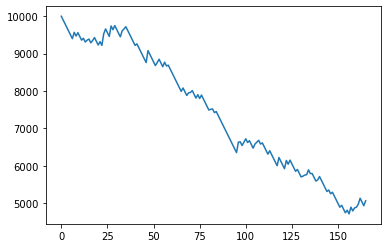

In [43]:
# 複勝
money = 10000
m = [10000]
a, b = 0, 0
atari = 0
for i in range(len(pre2)):
    a += 1
    if pre2.loc[i, "rank"] <= 3:
        d = returns.loc[(returns["0"] == "複勝") & (returns["id"] == str(pre2.loc[i, "id"]))]
        dn = list(list(d["1"])[0].split("br"))
        dp = list(list(d["2"])[0].split("br"))
        money += int(dp[pre2.loc[i, "rank"] - 1].replace(',', '')) - 100
        m.append(money)
        b += 1
        atari += int(dp[pre2.loc[i, "rank"] - 1].replace(',', ''))
    else:
        money -= 100
        m.append(money)
print(money)
print(b / a)
print(atari)
print(atari / a)
plt.plot(list(range(len(m))), m)
plt.show()

7620
0.34545454545454546
3120
56.72727272727273


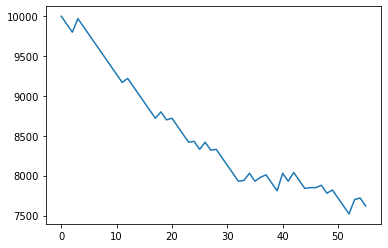

In [44]:
# 1 複勝
money = 10000
m = [10000]
a, b = 0, 0
atari = 0
for i in range(len(pre2)):
    if pre2.loc[i, "predrank"] == 1:
        a += 1
        if pre2.loc[i, "rank"] <= 3:
            d = returns.loc[(returns["0"] == "複勝") & (returns["id"] == str(pre2.loc[i, "id"]))]
            dn = list(list(d["1"])[0].split("br"))
            dp = list(list(d["2"])[0].split("br"))
            money += int(dp[pre2.loc[i, "rank"] - 1].replace(',', '')) - 100
            m.append(money)
            b += 1
            atari += int(dp[pre2.loc[i, "rank"] - 1].replace(',', ''))
        else:
            money -= 100
            m.append(money)
print(money)
print(b / a)
print(atari)
print(atari / a)
plt.plot(list(range(len(m))), m)
plt.show()

6370
0.10909090909090909
1870
34.0


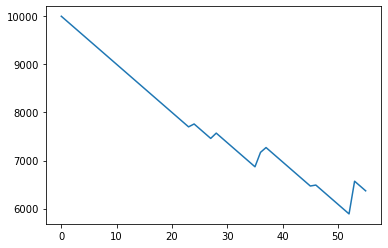

In [45]:
# 単勝
money = 10000
m = [10000]
a, b = 0, 0
atari = 0
for i in range(len(pre2)):
    if pre2.loc[i, "predrank"] == 1:
        a += 1
        if pre2.loc[i, "rank"] == 1:
            d = returns.loc[(returns["0"] == "単勝") & (returns["id"] == str(pre2.loc[i, "id"]))]
            dn = list(list(d["1"])[0].split("br"))
            dp = list(list(d["2"])[0].split("br"))
            money += int(dp[pre2.loc[i, "rank"] - 1].replace(',', '')) - 100
            m.append(money)
            b += 1
            atari += int(dp[pre2.loc[i, "rank"] - 1].replace(',', ''))
        else:
            money -= 100
            m.append(money)
print(money)
print(b / a)
print(atari)
print(atari / a)
plt.plot(list(range(len(m))), m)
plt.show()

In [46]:
# np.save('../Data/horse_id_dict.npy', horse_dict)
# np.save('../Data/jockey_id_dict.npy', jockey_dict)
horse_dict = np.load('../Data/horse_id_dict.npy', allow_pickle='TRUE').item()
jockey_dict = np.load('../Data/jockey_id_dict.npy', allow_pickle='TRUE').item()

In [47]:
df

,horse_id,date,枠番,性,齢,斤量,単勝,人気,fav,race_place,course_len,weather,race_type,race_type2,ground_state,前オッズ,前人気,前着順,pred_s,pred_t,pred_5,pred_3,pred_2,pred_1,pred_1235,pred_123,pred_m
0,2018100570,2021-06-12,1,1,3,54.0,3.7,1,19.23538,5,1200,0,1,0,2,2.7,1.0,11,17.153452,70.271268,0.815203,0.800463,0.734783,0.693719,3.044167,2.228965,1
1,2018104780,2021-06-12,1,2,3,56.0,10.4,6,0.36571,5,1200,0,1,0,2,5.6,3.0,2,17.148154,70.315416,0.666544,0.649706,0.595389,0.469384,2.381023,1.714479,3
2,2018101518,2021-06-12,2,1,3,52.0,275.3,16,0.16203,5,1200,0,1,0,2,372.5,15.0,16,16.896135,71.428741,0.083888,0.040074,0.061364,0.011709,0.197036,0.113148,16
3,2018101447,2021-06-12,2,2,3,56.0,57.7,11,0.18928,5,1200,0,1,0,2,42.2,12.0,13,17.027790,70.854708,0.286990,0.151254,0.074106,0.012311,0.524661,0.237671,10
4,2018105258,2021-06-12,3,2,3,56.0,3.9,2,3.49106,5,1200,0,1,0,2,3.8,2.0,2,17.154444,70.271268,0.800302,0.762711,0.715610,0.609443,2.888066,2.087764,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47471,2015110065,2021-09-05,6,0,6,57.0,82.5,11,0.22633,3,2600,2,1,0,2,27.5,6.0,7,16.016377,161.678886,0.277439,0.176766,0.083345,0.012813,0.550363,0.272924,12
47472,2017100368,2021-09-05,7,2,4,57.0,43.7,8,0.36519,3,2600,2,1,0,2,13.1,5.0,6,16.022843,161.678886,0.502155,0.436141,0.419261,0.281895,1.639451,1.137296,5
47473,2018104097,2021-09-05,7,2,3,53.0,46.5,9,0.28062,3,2600,2,1,0,2,47.7,9.0,9,15.955428,162.314611,0.404766,0.392535,0.391951,0.285211,1.474463,1.069697,5
47474,2017102850,2021-09-05,8,2,4,57.0,3.6,2,3.35410,3,2600,2,1,0,2,5.1,3.0,4,16.022019,161.678886,0.860116,0.860528,0.817015,0.717083,3.254742,2.394626,1


In [48]:
# url = "https://yoso.netkeiba.com/?pid=race_yoso_list&race_id=202205021211&type="
# url = "https://yoso.netkeiba.com/?pid=race_yoso_list&race_id=202205021212&type="
# url = "https://yoso.netkeiba.com/?pid=race_yoso_list&race_id=202207040111&rf=yoso_top_pc"
# url = "https://yoso.netkeiba.com/?pid=race_yoso_list&race_id=202205030211&rf=yoso_top_pc"
# url = "https://yoso.netkeiba.com/?pid=race_yoso_list&race_id=202205030411&rf=yoso_top_pc"
# url = "https://yoso.netkeiba.com/?pid=race_yoso_list&race_id=202209030411&rf=yoso_top_pc"
# url = "https://yoso.netkeiba.com/?pid=race_yoso_list&race_id=202209040711&type="  # 菊花賞
url = "https://yoso.netkeiba.com/?pid=race_yoso_list&race_id=202209050411&type="  #エリザベス女王
# url2 ="https://race.netkeiba.com/race/shutuba.html?race_id=202205021211&rf=race_submenu"
# url2 = "https://race.netkeiba.com/race/shutuba.html?race_id=202205021212&rf=race_submenu"
# url2 = "https://race.netkeiba.com/race/shutuba.html?race_id=202207040111&rf=race_submenu"
# url2 = "https://race.netkeiba.com/race/shutuba.html?race_id=202205030211&rf=race_submenu"
# url2 = "https://race.netkeiba.com/race/shutuba.html?race_id=202205030411&rf=race_submenu"
# url2 = "https://race.netkeiba.com/race/shutuba.html?race_id=202209030411&rf=race_submenu"
# url2 = "https://race.netkeiba.com/race/shutuba.html?race_id=202209040711&rf=race_submenu" 
url2 = "https://race.netkeiba.com/race/shutuba.html?race_id=202209050411&rf=race_list"
#メインとなるテーブルデータを取得
ddd = pd.read_html(url)[0].iloc[:8, :-1].iloc[:, :-1]
# ddd
um = list(pd.read_html(url2)[0].iloc[1:, 3])
waku = list(ddd.loc[0][::-1])
srs = list(ddd.loc[3][::-1])
ki = list(ddd.loc[4][::-1])
tt = list(ddd.loc[5][::-1])
on = list(ddd.loc[7][::-1])
sei, rei, seki = [], [], []
tyo, ozz, nin = [], [], []
kisyu, uma = [], []
for i in range(len(srs)):
    sei.append(srs[i][-2])
    rei.append(int(srs[i][-1]))
    seki.append(int(srs[i][:-4]))
    ozz.append(on[i][:int((len(on[i]) + 1) / 2)])
    nin.append(on[i][int((len(on[i]) + 1) / 2):-2])
    tyo.append(tt[i][2:])
    if ki[i] in jockey_dict:
        kisyu.append(jockey_dict[ki[i]])
    else:
        kisyu.append("0")
    if um[i] in horse_dict:
        uma.append(horse_dict[um[i]])
    else:
        uma.append("0")
um

['ローザノワール',
 'ピンハイ',
 'デアリングタクト',
 'マジカルラグーン',
 'ホウオウエミーズ',
 'イズジョーノキセキ',
 'アンドヴァラナウト',
 'ウインキートス',
 'スタニングローズ',
 'ナミュール',
 'ルビーカサブランカ',
 'ウインマリリン',
 'アカイイト',
 'ライラック',
 'テルツェット',
 'ウインマイティー',
 'ジェラルディーナ']

In [49]:
race = pd.DataFrame(columns=df.columns).drop(["date", "pred_t", "pred_s", "pred_m", 
              "pred_1", "pred_2", "pred_3", "pred_5", "pred_1235", "pred_123"
#                                               , "pred_m2", "pred_s2"
                                             ], axis=1)
import requests
from bs4 import BeautifulSoup
html = requests.get(url2)
html.encoding = "EUC-JP"
soup = BeautifulSoup(html.text, "html.parser")
cr = soup.find("div", attrs={"class": "RaceData01"}).find_all("span")[0].text
cr = soup.find("div", attrs={"class": "RaceData01"}).text.split(" ")[2:]

race["枠番"] = waku
# race["調教師"] = tyo
race["性"] = sei
race["齢"] = rei
race["斤量"] = seki
race["単勝"] = ozz
race["人気"] = nin
race["horse_id"] = uma
# race["jockey_id"] = kisyu
race["race_place"] = soup.find("div", attrs={"class": "RaceData02"}).find_all("span")[1].text
race["course_len"] = cr[0][1:-1]

race["race_type"] = cr[0][0]
race["race_type2"] = cr[1][1]
race["weather"] = cr[2][3]
race["ground_state"] = cr[3][3]

race['性'] = le_sei.transform(race['性'].values)
race['weather'] = le_we.transform(race['weather'].values)
race['race_type'] = le_ra.transform(race['race_type'].values)
race['race_type2'] = le_ra2.transform(race['race_type2'].values)
race['ground_state'] = le_gr.transform(race['ground_state'].values)
race['race_place'] = le_rp.transform(race['race_place'].values)

race["単勝"] = race["単勝"].astype("float64")
race["人気"] = race["人気"].astype("int64")
race["枠番"] = race["枠番"].astype("int64")
race['fav'] = favorite(race)
# race['性'] = le_sei.fit_transform(race['性'].values)
# race['weather'] = le_we.fit_transform(race['weather'].values)
# race['race_type'] = le_ra.fit_transform(race['race_type'].values)
# race['race_type2'] = le_ra2.fit_transform(race['race_type2'].values)
# race['ground_state'] = le_gr.fit_transform(race['ground_state'].values)
# race['race_place'] = le_rp.fit_transform(race['race_place'].values)
# race['調教師'] = le_tyo.fit_transform(race['調教師'].values)
race['horse_id'] = race['horse_id'].astype("int64")
# race['jockey_id'] = race['jockey_id'].astype("int64")
race['course_len'] = race['course_len'].astype("int64")
ho = read_csv("horse_2022_G")
ho = ho.rename(columns={'Unnamed: 0': 'id'})
ho = ho.sort_values(["id", "日付"], ascending=[True, True]).reset_index(drop=True)
ho = ho.drop(['映像', 'ﾀｲﾑ指数', '厩舎ｺﾒﾝﾄ', '備考', "R", "通過", "ペース",
              "勝ち馬(2着馬)", "馬場指数", "レース名", "馬番", "賞金"], axis=1)
ho = ho.dropna(subset=['天気', "枠番", "オッズ", "人気", "タイム", "上り", "着差"]).reset_index(drop=True)
ho["日付"] = pd.to_datetime(ho['日付'], format='%Y/%m/%d')
l1, l2, l3, l4, l5 = [], [], [], [],[]
for i in range(len(race)):
    if (race.loc[i, "horse_id"] == ho["id"]).sum() != 0:
        l = list(ho[(race.loc[i, "horse_id"] == ho["id"])].iloc[-1, [6, 7, 8, 13, 11]])
    else:
        l = [0, 0, 0, "0:00.0", "00"]
    l1.append(l[0])
    l2.append(l[1])
    l3.append(int(l[2]))
#     l4.append(l[3])
#     l5.append(l[4][1:])

race["前オッズ"] = l1
race["前人気"] = l2
race["前着順"] = l3
# race["前距離"] = l5
# race["前タイム"] = change_time(l4)
# race["前距離"] = race["前距離"].astype("int64")
# race["前スピード"] = race["前距離"] / race["前タイム"]
race["pred_s"] = model_s.predict(race, num_iteration=model_s.best_iteration)
race["pred_t"] = model_t.predict(race, num_iteration=model_t.best_iteration)
race["pred_5"] = pd.DataFrame(model_5.predict(race, num_iteration=
                     model_5.best_iteration))
race["pred_3"] = pd.DataFrame(model_3.predict(race, num_iteration=
                     model_3.best_iteration))
race["pred_2"] = pd.DataFrame(model_2.predict(race, num_iteration=
                     model_2.best_iteration))
race["pred_1"] = pd.DataFrame(model_1.predict(race, num_iteration=
                     model_1.best_iteration))
race["pred_1235"] = race.pred_5 + race.pred_3 + race.pred_2 + race.pred_1
race["pred_123"] = race.pred_3 + race.pred_2 + race.pred_1
race["pred_m"] = np.argmax(model_m.predict(race, 
            num_iteration=model_m.best_iteration), axis = 1)
# race["pred_m2"] = np.argmax(model_m2.predict(race, 
#             num_iteration=model_m2.best_iteration), axis = 1)
# race["pred_s2"] = model_s2.predict(race, num_iteration=model_s2.best_iteration)
race = race.fillna(0)
# race
pred_race = model.predict(race, num_iteration=model.best_iteration)
pre_race = []
for i in range(len(pred_race)):
    pre_race.append([i, pred_race[i]])
pre_race = pd.DataFrame(pre_race, columns=['id', 'pred'])
pre_race = pre_race.sort_values(["id", "pred"], ascending=[True, False]).reset_index(drop=True)
pre_race["id"] = pre_race["id"].astype("int64")
race.loc[list(np.argsort(list(pre_race["pred"]))[::-1])]

,horse_id,枠番,性,齢,斤量,単勝,人気,fav,race_place,course_len,weather,race_type,race_type2,ground_state,前オッズ,前人気,前着順,pred_s,pred_t,pred_5,pred_3,pred_2,pred_1,pred_1235,pred_123,pred_m
11,2017101431,7,1,5,56,10.1,5,0.56851,8,2200,2,1,0,3,60.2,9.0,16,15.962863,135.910285,0.700791,0.717473,0.673833,0.609728,2.701825,2.001033,1
16,2018105081,8,1,4,56,8.1,4,0.88939,8,2200,2,1,0,3,4.0,3.0,6,15.981963,136.521447,0.713350,0.723835,0.657357,0.530115,2.624657,1.911307,2
0,2016103084,1,1,6,56,83.2,15,0.10467,8,2200,2,1,0,3,194.8,18.0,4,15.947606,136.054823,0.244689,0.280303,0.421797,0.175890,1.122680,0.877990,2
8,2019105565,5,1,3,54,5.7,2,4.22049,8,2200,2,1,0,3,28.2,10.0,2,16.008874,136.491355,0.787316,0.739398,0.676353,0.528174,2.731241,1.943925,3
3,0,3,1,3,54,13.9,8,0.20596,8,2200,2,1,0,3,0.0,0.0,0,16.053216,135.880193,0.561236,0.530208,0.507397,0.217450,1.816291,1.255055,3
12,2017106203,7,1,5,56,24.4,11,0.12309,8,2200,2,1,0,3,41.8,12.0,8,15.958419,136.075590,0.466376,0.330293,0.281613,0.061117,1.139399,0.673024,4
9,2019105213,6,1,3,54,7.3,3,1.73324,8,2200,2,1,0,3,7.1,4.0,3,15.963985,136.521447,0.741038,0.732573,0.643065,0.343973,2.460649,1.719612,6
2,2017100720,2,1,5,56,4.3,1,20.73644,8,2200,2,1,0,3,8.4,5.0,6,15.986997,135.910285,0.696643,0.627458,0.598821,0.216578,2.139499,1.442856,6
6,2018105020,4,1,4,56,16.2,9,0.16563,8,2200,2,1,0,3,16.4,7.0,14,15.977578,136.521447,0.490047,0.357311,0.397666,0.362928,1.607953,1.117906,5
5,2017102294,4,1,5,56,17.5,10,0.13229,8,2200,2,1,0,3,0.0,0.0,0,16.041905,135.880193,0.473755,0.248969,0.087584,0.012481,0.822788,0.349034,5


In [50]:
list(race.loc[list(np.argsort(list(pre_race["pred"]))[::-1])].index)

[11, 16, 0, 8, 3, 12, 9, 2, 6, 5, 1, 15, 13, 7, 10, 14, 4]

In [51]:
ans_r = list(race.loc[list(np.argsort(list(pre_race["pred"]))[::-1])].index)
ans = pd.DataFrame(columns=["馬番","馬名", "人気", "オッズ"])
ans["馬名"] = um
ans["人気"] = nin
ans["オッズ"] = ozz
ans["馬番"] = list(range(1, len(ans) + 1))
# for i in range(len(ans_r)):
#     print(um[ans_r[i]], nin[ans_r[i]], "-", ozz[ans_r[i]])
ans.loc[list(race.loc[list(np.argsort(list(pre_race["pred"]))[::-1])].index)].reset_index(drop=True)

,馬番,馬名,人気,オッズ
0,12,ウインマリリン,5,10.1
1,17,ジェラルディーナ,4,8.1
2,1,ローザノワール,15,83.2
3,9,スタニングローズ,2,5.7
4,4,マジカルラグーン,8,13.9
5,13,アカイイト,11,24.4
6,10,ナミュール,3,7.3
7,3,デアリングタクト,1,4.3
8,7,アンドヴァラナウト,9,16.2
9,6,イズジョーノキセキ,10,17.5


In [52]:
race.sort_values(["pred_123"], ascending=[False])

,horse_id,枠番,性,齢,斤量,単勝,人気,fav,race_place,course_len,weather,race_type,race_type2,ground_state,前オッズ,前人気,前着順,pred_s,pred_t,pred_5,pred_3,pred_2,pred_1,pred_1235,pred_123,pred_m
11,2017101431,7,1,5,56,10.1,5,0.56851,8,2200,2,1,0,3,60.2,9.0,16,15.962863,135.910285,0.700791,0.717473,0.673833,0.609728,2.701825,2.001033,1
8,2019105565,5,1,3,54,5.7,2,4.22049,8,2200,2,1,0,3,28.2,10.0,2,16.008874,136.491355,0.787316,0.739398,0.676353,0.528174,2.731241,1.943925,3
16,2018105081,8,1,4,56,8.1,4,0.88939,8,2200,2,1,0,3,4.0,3.0,6,15.981963,136.521447,0.713350,0.723835,0.657357,0.530115,2.624657,1.911307,2
1,2019102772,2,1,3,54,11.8,6,0.38955,8,2200,2,1,0,3,51.5,13.0,4,15.934334,136.521447,0.634702,0.630320,0.625657,0.478061,2.368740,1.734038,7
9,2019105213,6,1,3,54,7.3,3,1.73324,8,2200,2,1,0,3,7.1,4.0,3,15.963985,136.521447,0.741038,0.732573,0.643065,0.343973,2.460649,1.719612,6
2,2017100720,2,1,5,56,4.3,1,20.73644,8,2200,2,1,0,3,8.4,5.0,6,15.986997,135.910285,0.696643,0.627458,0.598821,0.216578,2.139499,1.442856,6
3,0,3,1,3,54,13.9,8,0.20596,8,2200,2,1,0,3,0.0,0.0,0,16.053216,135.880193,0.561236,0.530208,0.507397,0.217450,1.816291,1.255055,3
6,2018105020,4,1,4,56,16.2,9,0.16563,8,2200,2,1,0,3,16.4,7.0,14,15.977578,136.521447,0.490047,0.357311,0.397666,0.362928,1.607953,1.117906,5
0,2016103084,1,1,6,56,83.2,15,0.10467,8,2200,2,1,0,3,194.8,18.0,4,15.947606,136.054823,0.244689,0.280303,0.421797,0.175890,1.122680,0.877990,2
12,2017106203,7,1,5,56,24.4,11,0.12309,8,2200,2,1,0,3,41.8,12.0,8,15.958419,136.075590,0.466376,0.330293,0.281613,0.061117,1.139399,0.673024,4


In [53]:
cc = res[(res["pred_3"] >= 0.5) & (res["pred_2"] >= 0.5) & (res["pred_1"] >= 0.5) & (res["pred_1235"] >= 2.0) & (res["pred_123"] >= 2)]
print(len(cc[(res2["着順"] <= 3)]) / len(cc))
print(len(cc))
print(len(qr))
# res2.loc[cc.index, "着順"]

0.4772727272727273
88
55


In [54]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
preds = np.round(model_3.predict(res.drop(["date", "pred_1", "pred_2", "pred_3", "pred_m", "pred_1235", "pred_123"], axis=1), num_iteration=model_3.best_iteration))
reals = topn(res2['着順'], 3)
print('Accuracy score = \t {}'.format(accuracy_score(reals, preds)))
print('Precision score = \t {}'.format(precision_score(reals, preds)))
print('Recall score =   \t {}'.format(recall_score(reals, preds)))
print('F1 score =      \t {}'.format(f1_score(reals, preds)))

Accuracy score = 	 0.6784841075794621
Precision score = 	 0.35347432024169184
Recall score =   	 0.7048192771084337
F1 score =      	 0.47082494969818917


              precision    recall  f1-score   support

           1       0.04      0.04      0.04        55
           2       0.05      0.05      0.05        55
           3       0.05      0.05      0.05        56
           4       0.11      0.11      0.11        54
           5       0.11      0.11      0.11        55
           6       0.07      0.07      0.07        55
           7       0.02      0.02      0.02        55
           8       0.04      0.04      0.04        55
           9       0.04      0.04      0.04        56
          10       0.08      0.08      0.08        53
          11       0.04      0.04      0.04        53
          12       0.02      0.02      0.02        48
          13       0.04      0.04      0.04        45
          14       0.03      0.03      0.03        40
          15       0.14      0.14      0.14        36
          16       0.04      0.04      0.04        28
          17       0.09      0.09      0.09        11
          18       0.25    

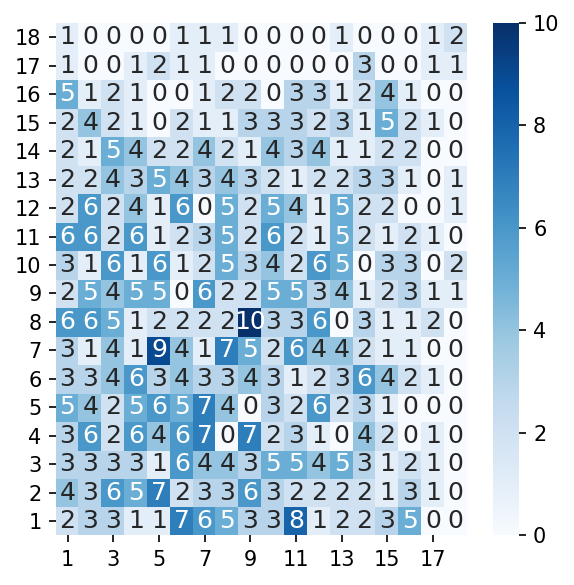

In [55]:
from sklearn.metrics import confusion_matrix, classification_report
labels = [1, 2, 3, 4]
re_labels = ["DS", "ML", "SE", "Cons"]
#混同行列の作成\n",
conf_mx = confusion_matrix(res2["着順"].tolist(), pre["rank"].tolist())
conf_df = pd.DataFrame(data=conf_mx, index=list(range(1, 19)), columns=list(range(1, 19)))
# index=[x + "(act)" for x in re_labels], columns=[x + "(pred)" for x in re_labels])
conf_df
plt.figure(figsize=(4, 4), dpi=150)
sns.heatmap(conf_df, cmap='Blues', annot=True, fmt='d', annot_kws={"size": 12}).invert_yaxis()
plt.tight_layout()
print(classification_report(res2["着順"], pre["rank"]))